## Final - Part B: Low level arrests analysis
#### Notebook: John Parks & Joshua Claxton | Group: Race as Vulnerability: The Relationship between Policing and Gentrification

In this phase of the code, we are importing Los Angeles Police Department OpenData portal on https://data.lacity.org/. We will clean this arrest data representing both low level (a variety of arrest typologies used in our reference literature to represent the specific kinds of police presence that occur alongside neighborhood displacement) and total arrests for 2017 and 2022 respectively. We create four distinct geodataframes. Subsequently, we merge with the census block groups, spatialize and map to get a general sense of the distribution, and then concatenate the four datasets. In the single geodataframe, by block group, we will calculate low level arrests as a percentage of total arrests in each year and then the change in those percentages. 

In [1]:
# standard data manipulation
import pandas as pd
import numpy as np
import requests 

# geospatial data manipulation/visualization
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import contextily as ctx
import json

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

# advanced graph visualization
import seaborn as sns
import plotly as pl
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# COLORS FOR MAPS
# colors_cmap = ["#d3d3d3", "#aa9cb4", "#826796", "#5c3379", "#a3b2c9", "#8383ac", "#64578f",
#                "#472b73", "#7492bf", "#5d6ba3", "#474788", "#32236e", "#4371b5", "#36539b", "#293781", "#1d1b68"]
colors_cmap = ["#d3d3d3", "#5c3379", "#472b73",  "#32236e",  "#1d1b68"]
cmap = matplotlib.colors.ListedColormap(colors_cmap) # general choropleth
colors = ["#AD9313", "#FFEEA2", "#FFDA33"]
colors_cmap = colors[::-1]
cmap_2 = matplotlib.colors.ListedColormap(colors_cmap) # arrests points

#### B1. Import & Clean & Graph
First, we pull in the census block groups and csv data files for arrests, which we filtered and downloaded the distinct files ourselves on the open data portal. We kept all races for individuals arrested because it's not particularly relevant when our gentrification index accounts for race as well as which race is getting displaced. In the portal, we only filtered by year and kinds of arrests, split into our low level typologies ("Moving Violations","Weapon Possession","Narcotic Drug Laws","DUI","Disorderly Conduct","Disturbing the Peace","Drunkenness","Misc Other Violations","Prostitution","Possession of Stolen Property") and then total arrests for that same year. We considered an API pipeline for interoperability (and it is just programatically cleaner and makes reproducing easier); however, the size of the data as well as using the API pull method kept crashing the Jupyter notebook memory.

We also create a function to clean the arrest data before merging with block groups as well as loop to concatenate them and get our percent change. 
NOTE: Block groups were pulled from the city portal and were already cleaned.

In [2]:
# import arrest data between 2017 and 2022 
gdf_bg = gpd.read_file('data/Census_Block_Groups_2020.geojson')
low_arrests_17 = pd.read_csv('data/Low Arrest Data 2017.csv')
low_arrests_17['year'] = '2017_low'
low_arrests_22 = pd.read_csv('data/Low Arrest Data 2022.csv')
low_arrests_22['year'] = '2022_low'
all_arrests_17 = pd.read_csv('data/Total Arrests 2017.csv')
all_arrests_17['year'] = '2017_all'
all_arrests_22 = pd.read_csv('data/Total Arrests 2022.csv')
all_arrests_22['year'] = '2022_all'

# Set up FIPS code, just in case, and coordinate reference system (mercator)
gdf_bg['FIPS'] ='06' + '037' + gdf_bg['CT20']
gdf_bg = gdf_bg.to_crs(epsg=3857)

Let's conduct a very generalized apporach to testing the hypothesis in the literature. We will expect to see an increase in black arrests (assuming the gentrified neighborhood is displacing black folks) in the areas with high amount of low typology arrests. Let's make a bar graph showing percent of black arrests in the top 10 areas where percent of low level arrests increased in the five year period. First, we'll identify those 10 areas. We will merge the four datasets to do so. Then we'll create a fresh dataframe based on those 10 areas, which we'll merge onto the demographic data. We'll drop the missing the rows and then graph.

In [3]:
# function counts our arrest typologies 
def count_arrest(data):
    temp_data = data.value_counts(subset=['Area Name']).reset_index(name='Count')
    temp_data = temp_data.rename(columns={'Count': data['year'][0]+' Count'})
    temp_data = temp_data.sort_values(by=['Area Name'])
    return temp_data

# loop to merge the arrest counts
results_2 = pd.DataFrame(columns=['Area Name'])
for data in [low_arrests_17, all_arrests_17, low_arrests_22, all_arrests_22]:
    # run the count function and merge 
    results_2 = results_2.merge(count_arrest(data), on='Area Name', how='outer') 

# the next few lines get the percent of black arrests in each year. then merges both years' data together
black_all_arrests_17 = all_arrests_17[['Area Name','Descent Code']]
black_all_arrests_17 = black_all_arrests_17.value_counts(subset=['Area Name','Descent Code'],
                                                         normalize = True).reset_index(name='Percent_Black_17')
black_all_arrests_17 = black_all_arrests_17.loc[black_all_arrests_17['Descent Code'] == 'B']

black_all_arrests_22 = all_arrests_22[['Area Name','Descent Code']]
black_all_arrests_22 = black_all_arrests_22.value_counts(subset=['Area Name','Descent Code'],
                                                         normalize = True).reset_index(name='Percent_Black_22')
black_all_arrests_22 = black_all_arrests_22.loc[black_all_arrests_22['Descent Code'] == 'B']
black_arrests = black_all_arrests_17.merge(black_all_arrests_22, left_on="Area Name",right_on="Area Name", how="outer")

# merge low arrests and total arrest by area with percent of black arrests by CBG 
black_arrests_for_map = results_2.merge(black_arrests, left_on="Area Name",right_on="Area Name", how="outer")
black_arrests_for_map['Factor_Black_17'] = black_arrests_for_map['Percent_Black_17']*1000
black_arrests_for_map['Factor_Black_22'] = black_arrests_for_map['Percent_Black_22']*1000

# calculate percentages
black_arrests_for_map['Percent_low_17'] = black_arrests_for_map['2017_low Count']/black_arrests_for_map['2017_all Count']
black_arrests_for_map['Percent_low_22'] = black_arrests_for_map['2022_low Count']/black_arrests_for_map['2022_all Count']
black_arrests_for_map['Percent_differential'] = ((black_arrests_for_map['Percent_low_22']-black_arrests_for_map['Percent_low_17'])/black_arrests_for_map['Percent_low_17'])*100

# sort values for map
black_arrests_for_map = black_arrests_for_map.sort_values('Percent_differential',ascending = False).head(20)

In [4]:
# NOTE: commented out to save on mem
# let's plot our findings from above
fig = go.Figure()

# set visual style
fig.add_trace(go.Bar(x=black_arrests_for_map['Area Name'],
                y=black_arrests_for_map['Factor_Black_17'],
                name='Black arrests factor 2017',
                marker_color='#5c3379',
                     opacity = .8
                ))

fig.add_trace(go.Bar(x=black_arrests_for_map['Area Name'],
                y=black_arrests_for_map['Factor_Black_22'],
                name='Black arrests factor 2022',
                marker_color='#4371b5',
                     opacity = .8
                ))

fig.add_hline(y=10, line_dash="dot")

fig.add_annotation(x=21, y=11,
            text="black arrest threshold",
                  showarrow = False)

fig.update_layout(
    title='Black Arrests in Precincts with High Prevalence of Low Level Arrests',
    title_y = .9,
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Black Arrests As Percent of Total Arrests',
        titlefont_size=14,
        tickfont_size=12,
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 ,# gap between bars of the same location coordinate.
    
    width=1500,
    height=750
)
fig.update_yaxes(showgrid=True, gridwidth=.5, gridcolor='#e0e0e0')
fig.write_html('Arrest_bar_graph.html')

Remarks: 
- That did not reveal much because we are not normalizing by the percent of black folks in that precinct and do not know the precinct boundaries well. Bar graphs are also not tremendously evocative. However, it still helps to visualize the data. Upon checking Google Maps, we do see that **_77th Street_** and **_Southeast_** are precincts in the South Central vicinity, where most of the black population in the city live and are potentially at risk of displacement, as gentrification proliferates south and eastward. Of those precincts with the most proportional low level arrests, these areas saw the highest increase in black arrests . 

Here we run a function that cleans the arrests by converting them into a geodatabase, assigning a mercator coordinate reference system, ensuring the coordinates are the right datatype and purged of superfluous outliers. We merge with the block groups to get the counts of arrest by block group. Then the function returns that new geodataframe, with everything done to it that we just did. 

In [5]:
# function for cleaning arrest data
def clean_arrest(arrests17):
       
        # convert dataframe to geodataframe
        arrests17 = gpd.GeoDataFrame(arrests17,
                                     crs='EPSG:4326',
                                     geometry=gpd.points_from_xy(arrests17.LON, arrests17.LAT))
        
        # confirm the latitude and longitude are float datatype and drop any instance(s) of 0,0 conundrum
        arrests17.LON = arrests17.LON.astype('float')
        arrests17.LAT = arrests17.LAT.astype('float')
        arrests17[arrests17.LON==0]
        arrests17 = arrests17[arrests17.LON!=0]
        
        # grab columns we care about and setting the coordinate system to mercator
        arrests17 = arrests17[['Area Name','Age','Descent Code','Sex Code','Charge Description','LAT','LON','geometry','year']]
        arrests17 = arrests17.to_crs(epsg=3857)
        
        # spatial join between block groups and arrests, and then get the counts of arrests by block group
        join = gpd.sjoin(arrests17,gdf_bg, how="left", predicate="within")
        arrests17_by_bg = join.BG20.value_counts().rename_axis('Block Group').reset_index(name='arrests_count')
        
        # create distinct year identifier for the dataset, and create an arrest count column with the year identifier
        arrests17_by_bg['year']=arrests17['year']
        arrests17_by_bg[arrests17['year'][0]]=arrests17_by_bg['arrests_count']
        
        # return output for loop
        return arrests17_by_bg

Here we reproduce the function but this time we produce maps using plotly express. We only run it once to save on memory. 

In [6]:
# NOTE: only run this once to save on Jupyter notebook memory. once htmls are produced for storymap comment everything out 
def map_arrest(arrests17):
            
        # merge the cleaned arrests (produced with the previous function) back with the census block groups 
        maparrest= gdf_bg.merge(clean_arrest(arrests17), left_on="BG20",right_on="Block Group", how="outer") 

        # drop blocks with no arrests
        maparrest = maparrest.dropna()
        df = maparrest

        # coordinate system as WGS84--this is necessary for plotly express (sigh...)
        df2 = df.to_crs(epsg=4326)
        
        # the following code til the end of the function is plotly express syntax for a choropleth map of census block groups based on arrest counts 
        df2['Arrests'] = df2['arrests_count']
        fig = px.choropleth_mapbox(df2, geojson=df2.geometry, locations=df2.index, color='Arrests',
                        
                                   mapbox_style="carto-positron",
                                   range_color=(1, 50),
                                   zoom=9.15, 
                                   center = {"lat": 34.02, "lon": -118.38411},
                                   opacity=0.60,
                                   hover_name = 'Block Group',
                                   color_continuous_scale = 'dense')


        fig.update_layout(width = 1200,
                          height = 800,
                          title = "Interactive Map - Counts of Arrests in Census Block Groups",
                          title_y=.96,
                          title_x=0.455)

        fig.write_html(arrests17['year'][0]+'_Interactive_Arrest_Totals_Block_Groups.html')
        

Our loop generates the four cleaned datasets of arrests and concatenates them, ready for the percentage calculations. It produces the maps too, but again we only do this once to save on storage.

In [7]:
# empty list and dataframe to put loop output into
results_2 = pd.DataFrame(columns=['Block Group'])

# loop over the four sets of arrest data: cleaning and then creating maps
for data in [low_arrests_17, all_arrests_17, low_arrests_22, all_arrests_22]:
    
    # run the cleaning function and concatenate
    results_2 = results_2.merge(clean_arrest(data), on='Block Group', how='outer')
    
    # run the mapping function
    map_arrest(data)

# check cleaned arrests output
results_2.head()

,Block Group,arrests_count_x,year_x,2017_low,arrests_count_y,year_y,2017_all,arrests_count_x,year_x,2022_low,arrests_count_y,year_y,2022_all
0,2063031,2197.0,2017_low,2197.0,3067.0,2017_all,3067.0,76.0,2022_low,76.0,182.0,2022_all,182.0
1,2062021,1620.0,2017_low,1620.0,1954.0,2017_all,1954.0,57.0,2022_low,57.0,128.0,2022_all,128.0
2,2063011,1209.0,2017_low,1209.0,1539.0,2017_all,1539.0,81.0,2022_low,81.0,180.0,2022_all,180.0
3,1282101,889.0,2017_low,889.0,1338.0,2017_all,1338.0,629.0,2022_low,629.0,803.0,2022_all,803.0
4,9800281,693.0,2017_low,693.0,1119.0,2017_all,1119.0,570.0,2022_low,570.0,872.0,2022_all,872.0


In [8]:
# only keep needed columns & merge block groups back on & calculate percentages
results_3 = results_2[['Block Group','2017_low','2017_all','2022_low','2022_all']]
results_3['BG20'] = results_3['Block Group']
spatial_total_arrests = gdf_bg.merge(results_3, left_on="BG20",right_on="BG20", how="outer")
# drop blocks with no arrests
arrests_clean = spatial_total_arrests.dropna()
arrests_clean = arrests_clean[['OBJECTID','FIPS','Block Group','2017_low',	'2017_all',	'2022_low',	'2022_all', 'geometry','ShapeSTArea','ShapeSTLength']]
# create percentage change column
arrests_clean['Percent_low_17'] = arrests_clean['2017_low']/arrests_clean['2017_all']
arrests_clean['Percent_low_22'] = arrests_clean['2022_low']/arrests_clean['2022_all']
arrests_clean['Percent_differential'] = ((arrests_clean['Percent_low_22']-arrests_clean['Percent_low_17'])/arrests_clean['Percent_low_17'])*100
arrests_clean.head()

,OBJECTID,FIPS,Block Group,2017_low,2017_all,2022_low,2022_all,geometry,ShapeSTArea,ShapeSTLength,Percent_low_17,Percent_low_22,Percent_differential
0,13178,06037101110,1011101,3.0,6.0,5.0,8.0,"POLYGON ((-13167813.274 4064147.812, -13167992...",4.814334e+06,8706.028022,0.500000,0.625000,25.000000
1,13179,06037101110,1011102,9.0,17.0,6.0,19.0,"POLYGON ((-13168131.314 4063708.046, -13168242...",3.814445e+06,8807.808535,0.529412,0.315789,-40.350877
2,13180,06037101110,1011103,8.0,21.0,3.0,7.0,"POLYGON ((-13168865.466 4064201.959, -13169186...",3.666842e+06,8335.115553,0.380952,0.428571,12.500000
3,13181,06037101122,1011221,2.0,9.0,1.0,6.0,"POLYGON ((-13168008.974 4065249.661, -13167998...",1.711345e+07,19507.471814,0.222222,0.166667,-25.000000
4,13182,06037101122,1011222,3.0,6.0,1.0,2.0,"POLYGON ((-13166583.750 4063754.918, -13166582...",1.134430e+07,19207.991527,0.500000,0.500000,0.000000


## Final - Part C: Spatial Autocorrelation of Arrests & Gentrification Overlay
#### Notebook: John Parks & Joshua Claxton | Group: Race as Vulnerability: The Relationship between Policing and Gentrification

In Part C, we take percent change column by block group to proportionally calculate spatial autocorrelation, which is the statistically significant clustered block groups of heightened low level arrests over the 5 year period based on their total arrests. We can then overlay the spatial autocorrelation with our gentrification index to visually and qualitatively inspect the spatial occurence (and what we predict to be co-occurence) of both phenomenon.

First we establish the weights based on "nearest neighbor" logic. This assigns spatial values that determine proximity of the block groups to each other. We will then compute the spatial lag, which assigns a value based a variable (percent differential in low level arrests) and the spatial weight associated with the surronding block groups that also have a high amount of low level arrests. We then map the raw percent differential in low level arrests and the spatial lag version in matplotlib.

In [9]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(arrests_clean,k=8)

# Row-standardization
wq.transform = 'r'

# create a new column for the spatial lag
arrests_clean['Percent_differential_lag'] = lps.weights.lag_spatial(wq, arrests_clean['Percent_differential'])
arrests_clean.sort_values('Percent_differential',ascending=False).head()

,OBJECTID,FIPS,Block Group,2017_low,2017_all,2022_low,2022_all,geometry,ShapeSTArea,ShapeSTLength,Percent_low_17,Percent_low_22,Percent_differential,Percent_differential_lag
2457,15635,06037274202,2742024,1.0,14.0,3.0,3.0,"POLYGON ((-13186971.136 4025204.785, -13186957...",1.025353e+06,4858.006744,0.071429,1.000000,1300.000000,-0.956899
119,13297,06037106407,1064072,1.0,22.0,8.0,15.0,"POLYGON ((-13183884.806 4070635.847, -13184282...",1.544411e+06,5035.571424,0.045455,0.533333,1073.333333,108.036808
1581,14759,06037212900,2129002,1.0,14.0,27.0,45.0,"POLYGON ((-13171387.296 4035701.957, -13171415...",2.068536e+06,6454.960680,0.071429,0.600000,740.000000,-1.684335
950,14128,06037181000,1810002,9.0,103.0,9.0,16.0,"POLYGON ((-13160785.895 4048892.697, -13160791...",1.205866e+07,19374.513183,0.087379,0.562500,543.750000,24.055514
201,13379,06037111201,1112012,8.0,53.0,10.0,12.0,"POLYGON ((-13191606.038 4065388.543, -13191604...",8.218900e+06,12096.538804,0.150943,0.833333,452.083333,-1.562206


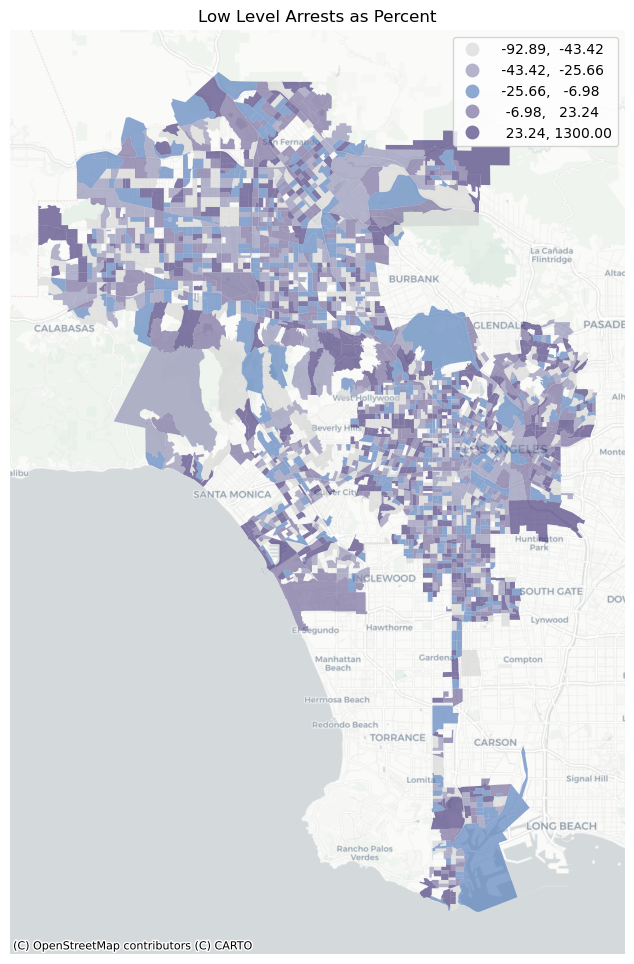

In [10]:
# NOTE: commented out to save on mem
# create individual plots for gif
colors_cmap = ["#d3d3d3","#8383ac","#4371B5","#64578F","#32236E"]
cmap = matplotlib.colors.ListedColormap(colors_cmap) # general choropleth
fig, ax = plt.subplots(figsize=(20, 12))

# regular percent differential map
arrests_clean.plot(ax=ax, # this assigns the map to the left subplot
                   column='Percent_differential',
                   cmap=cmap, 
                   scheme='quantiles',
                   k=5,
                   edgecolor='white',
                   legend = True,
                   linewidth=0,
                   alpha=0.6, 
                  )


ax.axis("off")
ax.set_title("Low Level Arrests as Percent")
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.savefig('png/Low Level Arrests as Percent.png')

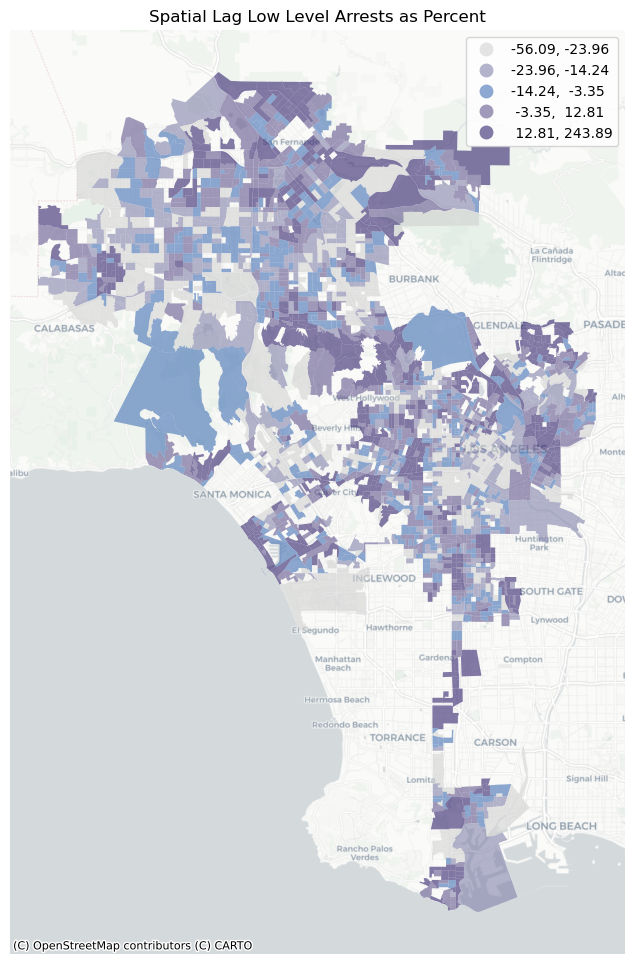

In [11]:
# NOTE: commented out to save on mem
# spatial lag map
fig, ax = plt.subplots(figsize=(20, 12))

arrests_clean.plot(ax=ax,
                   column='Percent_differential_lag',
                   legend=True,
                   cmap=cmap,
                   scheme='quantiles',
                   k=5, 
                   edgecolor='white', 
                   linewidth=0, 
                   alpha=0.6
                  )

ax.axis("off")
ax.set_title("Spatial Lag Low Level Arrests as Percent")
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
plt.savefig('png/Spatial Lag Low Level Arrests as Percent.png')

Remarks
- It appears in the map representing the lag that we generally see clusters in the South Central area. We also see clusters in th valley, in the northwest by Pasadena, and south by Gardena. The prevalence of low level arrests could occur for many reasons that we are not controlling for; however, we were not expecting an abundance of low level arrest clusters only in our area of interest. We are primarily interested in the overlay between the clusters we do see and the gentrificaiton hot spots.


Create the Moran's I statistical values and plot to represent the statistical correlation. The above maps are only representing clusters.

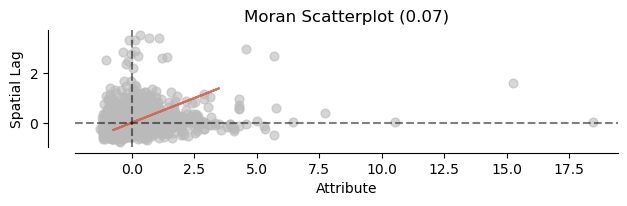

0.001

In [12]:
y = arrests_clean.Percent_differential
moran = Moran(y, wq)
# NOTE: commented out to save on mem
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()
moran.p_sim

We see a very slight positive correlation of .07, which means increases in low level arrests between the years only cluster slight

Very low P so we can reject the null hypothesis and conclude that there is a statistical significance to the spatial pattern we are seeing.

Now we will run local spatial autocorrelation to get our third and final map, representing the distribution of an increase in percent of low level arrests over the five year period.

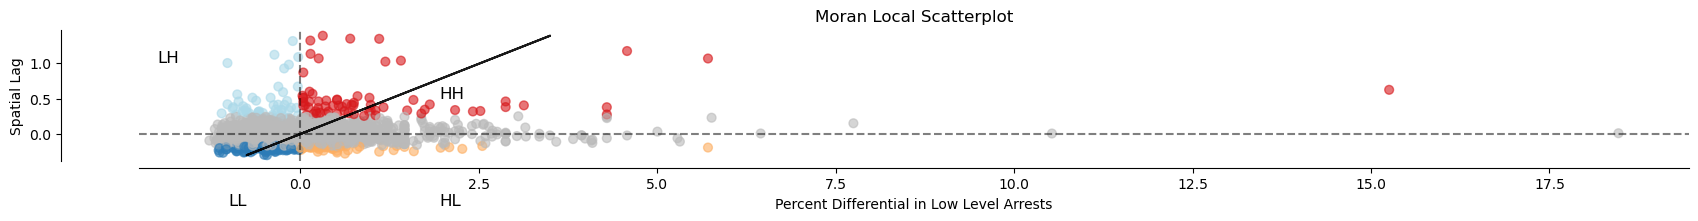

In [13]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

# NOTE: commented out to save on mem
# Plot
fig,ax = plt.subplots(figsize=(20,12))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Percent Differential in Low Level Arrests")
ax.set_ylabel('Spatial Lag')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=12)
plt.text(1.95, -1, "HL", fontsize=12)
plt.text(-2, 1, "LH", fontsize=12)
plt.text(-1, -1, "LL", fontsize=12)
plt.savefig('LISA_scatterplot.png')

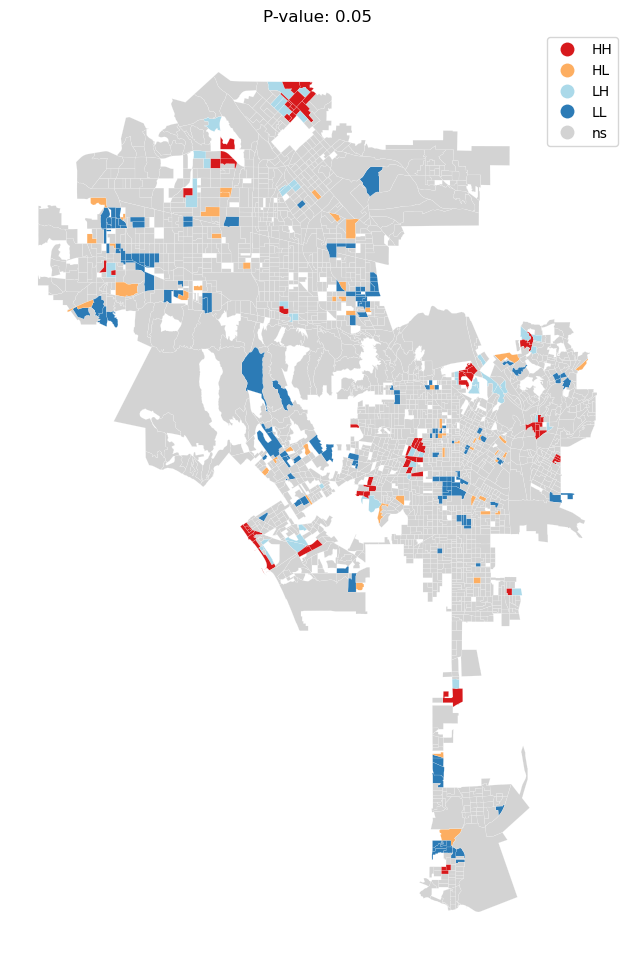

In [14]:
# NOTE: commented out to save on mem
# create the subplots for the gif
fig, ax = plt.subplots(figsize=(20, 12))
# .05
lisa_cluster(lisa, arrests_clean, p=0.05, ax=ax)
ax.axis("off")
ax.set_title("P-value: 0.05")
plt.savefig('png/05_Lisa.png')

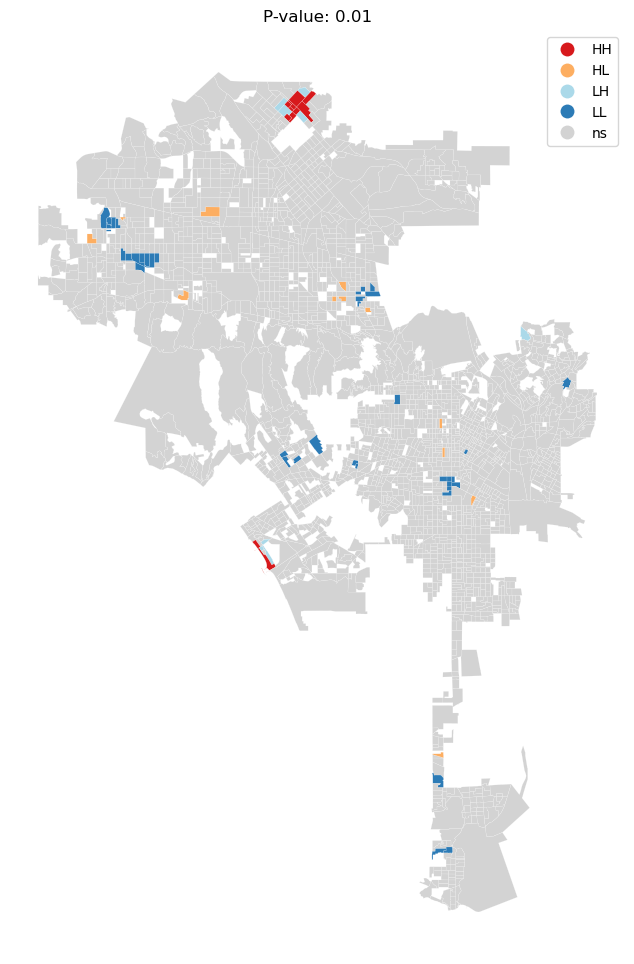

In [15]:
# NOTE: commented out to save on mem
# create the subplots for the gif
fig, ax = plt.subplots(figsize=(20, 12))
# .01
lisa_cluster(lisa, arrests_clean, p=0.01, ax=ax)
ax.axis("off")
ax.set_title("P-value: 0.01")
plt.savefig('png/01_Lisa.png')

Make a GIF of the maps!

In [16]:
# NOTE: commented out to save on mem
import os
import imageio

png_dir = 'png'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('Spatial_Autocorrelation.gif', images, duration = 3)

#### C2. Overlay
We will overlay our spatial lag geodatadrame of arrests on the gentrification index and qualitatively evaluate based on the statistically significant clusters from the spatial autocorrelation.

In [17]:
# create points to overlay on gentrification index
arrests_clean = arrests_clean.to_crs(4326)
arrests_clean['Centroid']=arrests_clean.to_crs('+proj=cea').centroid.to_crs(arrests_clean.crs)
arrests_clean = arrests_clean.to_crs(4326)
arrests_clean['lon'] = arrests_clean.Centroid.x
arrests_clean['lat'] = arrests_clean.Centroid.y

# import gentrification index from Part A
index = pd.read_csv('data/index.csv')
index = index[['name','Gentrification Level']]
# import LA neighborhoods from ArcGIS
nbh = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

# spatial join on dataframes created above and neighborhood geodataframe
index = index.merge(nbh, how="left", on="name")
index = index.set_geometry('geometry')

In [18]:
arrests_clean.head()

,OBJECTID,FIPS,Block Group,2017_low,2017_all,2022_low,2022_all,geometry,ShapeSTArea,ShapeSTLength,Percent_low_17,Percent_low_22,Percent_differential,Percent_differential_lag,Centroid,lon,lat
0,13178,06037101110,1011101,3.0,6.0,5.0,8.0,"POLYGON ((-118.28848 34.26282, -118.29009 34.2...",4.814334e+06,8706.028022,0.500000,0.625000,25.000000,-5.440885,POINT (-118.28814 34.25936),-118.288142,34.259364
1,13179,06037101110,1011102,9.0,17.0,6.0,19.0,"POLYGON ((-118.29134 34.25956, -118.29233 34.2...",3.814445e+06,8807.808535,0.529412,0.315789,-40.350877,-1.893939,POINT (-118.29610 34.25782),-118.296105,34.257816
2,13180,06037101110,1011103,8.0,21.0,3.0,7.0,"POLYGON ((-118.29793 34.26323, -118.30082 34.2...",3.666842e+06,8335.115553,0.380952,0.428571,12.500000,-14.125299,POINT (-118.29615 34.26136),-118.296146,34.261358
3,13181,06037101122,1011221,2.0,9.0,1.0,6.0,"POLYGON ((-118.29024 34.27100, -118.29015 34.2...",1.711345e+07,19507.471814,0.222222,0.166667,-25.000000,4.782197,POINT (-118.29470 34.27095),-118.294703,34.270950
4,13182,06037101122,1011222,3.0,6.0,1.0,2.0,"POLYGON ((-118.27743 34.25991, -118.27743 34.2...",1.134430e+07,19207.991527,0.500000,0.500000,0.000000,12.039474,POINT (-118.28330 34.26286),-118.283305,34.262862


In [19]:
arrests_clean=arrests_clean.loc[(arrests_clean['Percent_differential_lag'] >0) & (arrests_clean['Percent_differential_lag'] <110)]

In [20]:
# generate choropleth map of the gentrification as well as the overlay of low level arrest factor
fig = px.choropleth_mapbox(index, geojson=index['geometry'], locations=index.index, color='Gentrification Level',
                           mapbox_style="carto-positron",
                           range_color=(),
                           zoom=9.15,
                           center = {"lat": 34.02, "lon": -118.38},
                           opacity=0.6,
                           hover_name = 'name',
                           color_continuous_scale = 'dense',
                           color_discrete_sequence= px.colors.qualitative.G10,
                           color_discrete_map={"Very High": "#682573","High": "#7863c9", "Medium": "#7fafe4", "Low": "#d1e6ea"})

# arrests 
fig2 = px.scatter_mapbox(arrests_clean, lat="lat", lon="lon", hover_name="Block Group",
                         hover_data=["Percent_differential_lag"], color = 'Percent_differential_lag',
                         color_continuous_scale=px.colors.sequential.YlOrRd,
                         range_color=(0, 100),
                         color_continuous_midpoint=100)

# options on the layout
fig.update_coloraxes(autocolorscale=False, cauto=False, colorscale=[[0, 'rgb(225,114,48)'], [0.5, 'rgb(255,177,62)'],[1, 'rgb(255,214,48)']])
fig.update_layout(width = 1000,
                  height = 800,
                  title = 'Interactive Gentrification Index, Overlayed with Low Level Arrests Spatial Lag',
                  title_y=.96,
                  title_x=.1,
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="left",
                              x=0.01)) 

fig.add_trace(fig2.data[0])
fig.write_html('G_Arrests.html')


Remarks & Conclusion
- We see spatial dispersion of our spatial lag variable representing 5-year period increases in low level arrests. This is expected because there are myriad factors that could lead to such changes in this typology of arrests over time. However, based on our research, we thought we would see most neighborhoods marked as "high" gentrification containing the highest concentrations of **increased** low level arrests. Granada Hills, Silver Lake, Mid-City, West Adams, Jefferson Park, and Baldwin Hills/Crenshaw all contained "hot spot" census blocks groups where the low level arrests saw an increase and are surronded by statistically significant amount of other block groups with an increase. Anecdotally, as LA residents, we know these neighborhoods to have experienced significant demographic and economic change over the years, tend to have persistent police presence, and likely have gone through cycles of displacement. We conclude that the hypothesis has validity, but we would likely need to get more specific in both our gentrification index inputs, control variables, and the kinds of arrests we are analyzing. There is tremendous potential for this to project to scale and contribute to as well as merge with ideas from the [Urban Displacement Project](https://www.urbandisplacement.org/) and [Million Dollar Hoods initiative](https://milliondollarhoods.pre.ss.ucla.edu/). 